# はじめてのNNabla

[関数近似で学ぶ chainer とディープラーニング](http://qiita.com/ashitani/items/1dc0a54da218ec224ad8)
の内容をNNablaで実装してみます。

In [1]:
import nnabla as nn

import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
from nnabla.monitor import tile_images

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2017-08-17 03:56:49,434 [nnabla][INFO]: Initializing CPU extension...


データを作成します。

In [2]:
def get_batch(n):
    x = np.random.random(n)
    y = np.exp(x)
    return x,y

グラフを作成します。leaky ReLUがないのでeluで代用します。

ミニバッチのサイズがネットワーク側に含まれるのがちょっと違和感です。predictionの際に必要な入力が１データであっても100個ぶんの計算をしないといけないことになりますが、このページの下のほうに解決策があります。

PFについてはscopeを定義してもよいし、name引数を指定してもよいですが、指定しないとaffineの名前空間が被ってエラーになります。affine二個目でエラーになるので一瞬わけがわからなかった。

In [3]:
batch_size = 100

x = nn.Variable((batch_size,1))
h1 = F.elu(PF.affine(x, 16,name="affine1"))
h2 = F.elu(PF.affine(h1, 32,name="affine2"))
y = F.elu(PF.affine(h2, 1,name="affine3"))

ロス関数を定義します。

In [4]:
t = nn.Variable((batch_size,1))
loss = F.mean(F.squared_error(y, t))

forward()してみます。Valirableは.dでデータにアクセスできるようです。リードもライトも可能なようです。.dataと.dは同じ意味。

In [5]:
dat=get_batch(batch_size)
x.d=dat[0].reshape((batch_size,1))
t.d=dat[1].reshape((batch_size,1))
loss.forward()
y.d[0]

array([-0.16410553], dtype=float32)

パラメータには下記のようにアクセスできるようです。なるほど。

In [6]:
params=nn.get_parameters()
print(params["affine1/affine/W"].d)

[[-0.5213632   0.17095006  0.33979338  0.49241149  0.52247387  0.26255551
   0.0197825   0.52184296 -0.09840396 -0.34245464  0.42117459 -0.0777697
  -0.18181679  0.3107743  -0.51719356 -0.28285319]]


solverの定義と学習です。

In [7]:
solver = S.Adam()
solver.set_parameters(nn.get_parameters())

In [8]:
losses=[]
for i in range(10000):
    dat=get_batch(batch_size)
    x.d=dat[0].reshape((batch_size,1))
    t.d=dat[1].reshape((batch_size,1))
    loss.forward()
    solver.zero_grad()
    loss.backward()
    solver.update()
    losses.append(loss.d.copy())
    if i % 1000 == 0:  # Print for each 10 iterations
        print(i, loss.d)

0 3.022484064102173
1000 0.006242163944989443
2000 0.005275368690490723
3000 0.002720302902162075
4000 0.00043357760296203196
5000 0.00019374849216546863
6000 7.523653766838834e-05
7000 6.410327478079125e-05
8000 2.9719907615799457e-05
9000 2.1921317966189235e-05


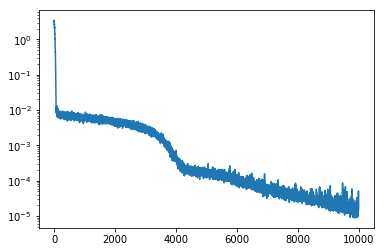

In [9]:
plt.plot(losses)
plt.yscale('log')

predictionをしてみましょう。任意のサブグラフに対してforward()ができるのですね。これは直感的です。

In [10]:
x.d= 0.2
y.forward()

In [11]:
print(y.d[0][0])
print(np.exp(0.2))

1.22677
1.22140275816


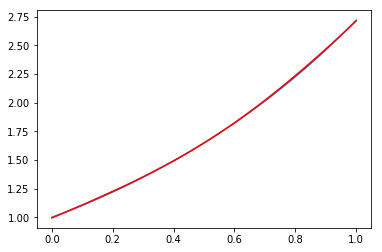

In [12]:
xi=np.linspace(0,1,100)
plt.plot(xi,np.exp(xi))
x.d = xi.reshape((100,1))
y.forward()
_=plt.plot(xi, y.d,"r")

save/loadはこれでいいのかな。すべてのparameterを保存するようですね。

In [13]:
nn.save_parameters("param_nnabla_first.h5")

2017-08-17 03:57:04,508 [nnabla][INFO]: Parameter save (hdf5): param_nnabla_first.h5


下記スクリプトでパラメータを読み出して実行できました。prediction用にバッチサイズを1にしても、パラメータの数は変わらないのでload_parameters()の後にforward()できるようですね。

```py
import nnabla as nn
import nnabla.functions as F
import nnabla.parametric_functions as PF

import numpy as np
import matplotlib.pyplot as plt

batch_size = 1

x = nn.Variable((batch_size,1))
h1 = F.elu(PF.affine(x, 16,name="affine1"))
h2 = F.elu(PF.affine(h1, 32,name="affine2"))
y = F.elu(PF.affine(h2, 1,name="affine3"))

nn.load_parameters("param_nnabla_first.h5")

xi=np.linspace(0,1,100)
plt.plot(xi,np.exp(xi))

ys=[]
for i in range(100):
    x.d = xi[i]
    y.forward()
    ys.append(y.d.copy())
_=plt.plot(xi, np.array(ys).reshape((100,)),"r")

plt.show()
```